In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# https://www.kaggle.com/hhs/health-insurance-marketplace
# https://www.kaggle.com/shelars1985/exploring-health-insurance-marketplace

In [2]:
def fetch_sql(query):
    conn = sqlite3.connect('../data/sql/database.sqlite')
    cur = conn.cursor()
    coords = cur.execute(query).fetchall()
    cur.close()
    conn.close()
    return coords

In [3]:
def fetch_sql_df(query):
    conn = sqlite3.connect('../data/sql/database.sqlite')
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [4]:
query = '''SELECT name FROM sqlite_master
           WHERE type='table'
           ORDER BY name;'''

q = fetch_sql(query)
q

[('BenefitsCostSharing',),
 ('BusinessRules',),
 ('Crosswalk2015',),
 ('Crosswalk2016',),
 ('Network',),
 ('PlanAttributes',),
 ('Rate',),
 ('ServiceArea',)]

In [5]:
tables = []
for i in q:
    tables.append(i[0])
tables

['BenefitsCostSharing',
 'BusinessRules',
 'Crosswalk2015',
 'Crosswalk2016',
 'Network',
 'PlanAttributes',
 'Rate',
 'ServiceArea']

In [6]:
table_columns = {}

for t in tables:
    query = 'SELECT * FROM ' + t + ' LIMIT 1'
    df = fetch_sql_df(query)
    table_columns[t] = list(df.columns)

table_columns

{'BenefitsCostSharing': ['BenefitName',
  'BusinessYear',
  'CoinsInnTier1',
  'CoinsInnTier2',
  'CoinsOutofNet',
  'CopayInnTier1',
  'CopayInnTier2',
  'CopayOutofNet',
  'EHBVarReason',
  'Exclusions',
  'Explanation',
  'ImportDate',
  'IsCovered',
  'IsEHB',
  'IsExclFromInnMOOP',
  'IsExclFromOonMOOP',
  'IsStateMandate',
  'IsSubjToDedTier1',
  'IsSubjToDedTier2',
  'IssuerId',
  'IssuerId2',
  'LimitQty',
  'LimitUnit',
  'MinimumStay',
  'PlanId',
  'QuantLimitOnSvc',
  'RowNumber',
  'SourceName',
  'StandardComponentId',
  'StateCode',
  'StateCode2',
  'VersionNum'],
 'BusinessRules': ['BusinessYear',
  'StateCode',
  'IssuerId',
  'SourceName',
  'VersionNum',
  'ImportDate',
  'IssuerId2',
  'TIN',
  'ProductId',
  'StandardComponentId',
  'EnrolleeContractRateDeterminationRule',
  'TwoParentFamilyMaxDependentsRule',
  'SingleParentFamilyMaxDependentsRule',
  'DependentMaximumAgRule',
  'ChildrenOnlyContractMaxChildrenRule',
  'DomesticPartnerAsSpouseIndicator',
  'SameS

In [9]:
query = 'SELECT * FROM BenefitsCostSharing LIMIT 10;'
df = fetch_sql_df(query)
df

,BenefitName,BusinessYear,CoinsInnTier1,CoinsInnTier2,CoinsOutofNet,CopayInnTier1,CopayInnTier2,CopayOutofNet,EHBVarReason,Exclusions,...,LimitUnit,MinimumStay,PlanId,QuantLimitOnSvc,RowNumber,SourceName,StandardComponentId,StateCode,StateCode2,VersionNum
0,Routine Dental Services (Adult),2014,20%,,20%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,68,HIOS,21989AK0010001,AK,AK,6
1,Dental Check-Up for Children,2014,20%,,20%,No Charge,,No Charge,Substantially Equal,,...,Visit(s) per 6 Months,,21989AK0010001-00,Yes,104,HIOS,21989AK0010001,AK,AK,6
2,Basic Dental Care - Child,2014,40%,,40%,No Charge,,No Charge,Substantially Equal,,...,,,21989AK0010001-00,,110,HIOS,21989AK0010001,AK,AK,6
3,Orthodontia - Child,2014,50%,,50%,No Charge,,No Charge,Additional EHB Benefit,,...,,,21989AK0010001-00,,111,HIOS,21989AK0010001,AK,AK,6
4,Major Dental Care - Child,2014,50%,,50%,No Charge,,No Charge,Substantially Equal,,...,,,21989AK0010001-00,,112,HIOS,21989AK0010001,AK,AK,6
5,Basic Dental Care - Adult,2014,40%,,40%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,113,HIOS,21989AK0010001,AK,AK,6
6,Orthodontia - Adult,2014,,,,,,,,,...,,,21989AK0010001-00,,114,HIOS,21989AK0010001,AK,AK,6
7,Major Dental Care - Adult,2014,50%,,50%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,115,HIOS,21989AK0010001,AK,AK,6
8,Accidental Dental,2014,,,,,,,,,...,,,21989AK0010001-00,,118,HIOS,21989AK0010001,AK,AK,6
9,Routine Dental Services (Adult),2014,20%,,20%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-01,Yes,68,HIOS,21989AK0010001,AK,AK,6


In [8]:
query = '''SELECT COUNT(*)
           FROM BenefitsCostSharing'''

total_records = fetch_sql(query)

print('Total records in file:', total_records[0][0])

Total records in file: 5048408


In [27]:
col = table_columns['BenefitsCostSharing']
for c in col:
    query = """SELECT COUNT({}) 
                FROM BenefitsCostSharing 
                WHERE {} = '';""".format(c, c)
    q = fetch_sql(query)
    print(c, q[0][0], round((q[0][0]/5048408*100),2))

BenefitName 0 0.0
BusinessYear 0 0.0
CoinsInnTier1 1113847 22.06
CoinsInnTier2 4571587 90.56
CoinsOutofNet 1113847 22.06
CopayInnTier1 1113847 22.06
CopayInnTier2 4571587 90.56
CopayOutofNet 1113849 22.06
EHBVarReason 3020737 59.84
Exclusions 4572247 90.57
Explanation 4075700 80.73
ImportDate 0 0.0
IsCovered 215980 4.28
IsEHB 1817362 36.0
IsExclFromInnMOOP 983986 19.49
IsExclFromOonMOOP 982626 19.46
IsStateMandate 4250463 84.19
IsSubjToDedTier1 2465877 48.84
IsSubjToDedTier2 2466054 48.85
IssuerId 0 0.0
IssuerId2 0 0.0
LimitQty 4360725 86.38
LimitUnit 4360539 86.37
MinimumStay 5031681 99.67
PlanId 0 0.0
QuantLimitOnSvc 3264532 64.66
RowNumber 0 0.0
SourceName 0 0.0
StandardComponentId 0 0.0
StateCode 0 0.0
StateCode2 0 0.0
VersionNum 0 0.0


In [9]:
query = """SELECT COUNT (DISTINCT BenefitName)
           FROM BenefitsCostSharing
           """
unique_benifits = fetch_sql(query)

print('Unique benefits present in file:', unique_benifits[0][0])

Unique benefits present in file: 861


In [17]:
col = table_columns['BenefitsCostSharing']
for c in col:
    print(c)
    query = """SELECT {} FROM BenifitsCostSharing;""".format(c)
    print(query)
    q = fetch_sql_df(query)
    print(q)
    break

BenefitName
SELECT BenefitName FROM BenifitsCostSharing;


DatabaseError: Execution failed on sql 'SELECT BenefitName FROM BenifitsCostSharing;': no such table: BenifitsCostSharing

In [42]:
query = """SELECT COUNT (BenefitName), COUNT (DISTINCT BenefitName), BusinessYear
           FROM BenefitsCostSharing
           GROUP BY BusinessYear;
           """

fetch_sql_df(query)

,COUNT (BenefitName),COUNT (DISTINCT BenefitName),BusinessYear
0,1164869,496,2014
1,2079286,517,2015
2,1804253,429,2016


In [142]:
query = """SELECT year, name
           FROM (SELECT BusinessYear as year, Benefitname as name, COUNT(*),
                        ROW_NUMBER() OVER (PARTITION BY BusinessYear 
                                           ORDER BY COUNT(*) DESC) as rn
                 FROM BenefitsCostSharing
                 GROUP BY BusinessYear, Benefitname
                 ) t
           WHERE rn = 1;"""

fetch_sql_df(query)

,year,name
0,2014,Routine Dental Services (Adult)
1,2015,Orthodontia - Adult
2,2016,Orthodontia - Adult


In [140]:
query = """SELECT StateCode AS State, COUNT(BenefitName) AS NumBenefits
           FROM BenefitsCostSharing
           GROUP BY StateCode
           ORDER BY StateCode;"""

state_df = fetch_sql_df(query)

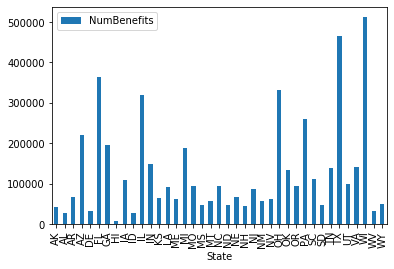

In [139]:
state_df.plot(kind='bar', x='State')

In [143]:
query = """SELECT State, name
           FROM (SELECT StateCode AS State, Benefitname as name, COUNT(*),
                        ROW_NUMBER() OVER (PARTITION BY StateCode 
                                           ORDER BY COUNT(*) DESC) as rn
                 FROM BenefitsCostSharing
                 GROUP BY StateCode, Benefitname
                 ) t
           WHERE rn = 1;"""

fetch_sql_df(query)

,State,name
0,AK,Routine Dental Services (Adult)
1,AL,Routine Dental Services (Adult)
2,AR,Orthodontia - Adult
3,AZ,Routine Dental Services (Adult)
4,DE,Routine Dental Services (Adult)
5,FL,Routine Dental Services (Adult)
6,GA,Routine Dental Services (Adult)
7,HI,Routine Dental Services (Adult)
8,IA,Routine Dental Services (Adult)
9,ID,Routine Dental Services (Adult)
